# The Perceptron

This notebook implements the Perceptron, which is a single neural model. The Perceptron is a supervised learning algorithm for binary classification.

---

First, load the relevant libraries needed.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Import a nice function for plotting decision boudaries
from mlxtend.plotting import plot_decision_regions

# Set the Seaborn theme
sns.set_theme()

# Import functions from scikit-learn to help with training/testing endeavors
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

## The Data

The model will be trained using the [Hawks](https://github.com/kary5678/INDE-577/blob/main/Data/hawks.csv) dataset. This dataset contains observations for three species of hawks, and attributes such as age, sex, wing length, body weight, tail length, etc. 

The code block below reads the dataset into a pandas DataFrame object, subsets the DataFrame to the relevant variables, and drops any rows where there are missing values for these relevant variables.

In [2]:
# Read in the data and subset it to the relevant columns/observations
hawks = pd.read_csv("../../Data/hawks.csv")
hawks = hawks[["Species", "Wing", "Tail", "Weight", "Culmen", "Hallux"]].dropna(axis=0)
hawks

,Species,Wing,Tail,Weight,Culmen,Hallux
0,RT,385.0,219,920.0,25.7,30.1
2,RT,381.0,235,990.0,26.7,31.3
3,CH,265.0,220,470.0,18.7,23.5
4,SS,205.0,157,170.0,12.5,14.3
5,RT,412.0,230,1090.0,28.5,32.2
...,...,...,...,...,...,...
903,RT,380.0,224,1525.0,26.0,27.6
904,SS,190.0,150,175.0,12.7,15.4
905,RT,360.0,211,790.0,21.9,27.6
906,RT,369.0,207,860.0,25.2,28.0


## Implementing the Algorithm

The class below contains methods that are useful to implementing the Perceptron algorithm from scratch.

For details about the algorithm, check out the `README.md` in this directory.

In [3]:
class MyPerceptron(object):
    """
    A class to fit the perceptron model to data.

    ...

    Attributes
    ----------
    eta: a float denoting the learning rate
    epochs: an integer denoting the maximum number of iterations allowed during model training
    w_: numpy array (of floats)
        Parameters of the trained models, organized as [w_bias, w_1, w_2, ..., w_n]
    errors_: list of floats
        Each entry in this list is an error calculated during training iterations
    
    """
    def __init__(self, eta = .5, epochs=50):
        self.eta = eta
        self.epochs = epochs
        
    def train(self, X, y):
        """
        Train a perceptron on the data

        Parameters
        ----------
        X: matrix of feature values
        y: array of observed values

        Returns: None
        """
        # Initialize coefficients/weights and intercept/bias from a uniform distribution
        self.w_ = np.random.rand(1 + X.shape[1])
        
        self.errors_ = []
        
        # Implement stochastic gradient decent
        for _ in range(self.epochs):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (self.predict(xi) - target)
                self.w_[:-1] -= update*xi
                self.w_[-1] -= update
                errors += int(update != 0)
            if errors == 0:
                return self
            else:
                self.errors_.append(errors)
            
        return self
    
    def net_input(self, X):
        """
        Calculate the weighted sum for the input data
        """
        return np.dot(X, self.w_[:-1]) + self.w_[-1]
    
    def predict(self, X):
        """
        Using the trained model, predict the class of new observations
        Can consider this as the step/activation function 
        """
        return np.where(self.net_input(X) >= 0.0, 1, -1)

## Model 1: Binary Classification Using 2 Predictors (Wing & Tail Length)

Observe that the `Species` is a variable consisting of 3 categories:

1. `RT`: Red-tailed
2. `CH`: Cooper's
3. `SS`: Sharp-Shinned

The perceptron is a binary classification method, so we will have to collapse these categories. From `hawks_analysis.ipynb` ([link](https://github.com/kary5678/INDE-577/blob/main/Data/hawks_analysis.ipynb)), I observe that the Cooper's and sharp-shinned hawks are clustered relatively near each other.  Furthermore, there are disproportionate counts of each species in the dataset; there are far more red-tailed hawks. Therefore, I will combined the Cooper's and sharp-shinned hawks into a single "not red-tailed" group. The classification task will then be to identify if a hawk is red-tailed or not red-tailed, given it's wing length and tail length. As there is a clear clustering for each group based on their wing and tail lengths, classification is a viable goal. 

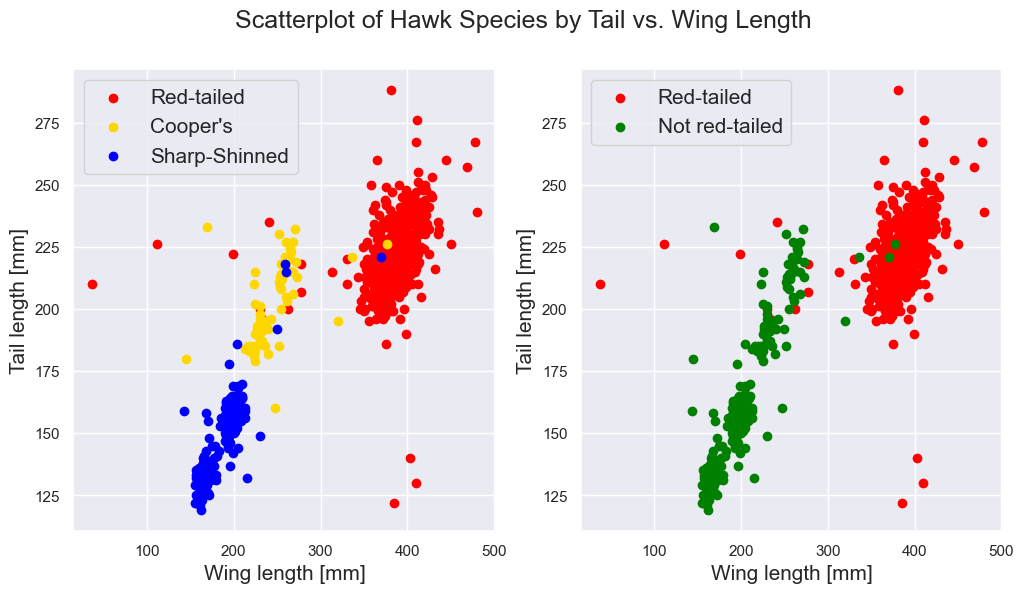

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
fig.suptitle("Scatterplot of Hawk Species by Tail vs. Wing Length", fontsize = 18)
# Produce a scatterplot of tail vs. wing length, color-coded by hawk species
RT = hawks[hawks.Species == "RT"]
CH = hawks[hawks.Species == "CH"]
SS = hawks[hawks.Species == "SS"]
ax1.scatter(RT.Wing, RT.Tail, color = "red", label = "Red-tailed")
ax1.scatter(CH.Wing, CH.Tail, color = "gold", label = "Cooper's")
ax1.scatter(SS.Wing, SS.Tail, color = "blue", label = "Sharp-Shinned")
ax1.set_xlabel("Wing length [mm]", fontsize = 15)
ax1.set_ylabel("Tail length [mm]", fontsize = 15)
ax1.legend(fontsize = 15, loc = "upper left")

# Produce a scatterplot of tail vs. wing length, color-coded by hawk species
NRT = hawks[hawks.Species != "RT"]
ax2.scatter(RT.Wing, RT.Tail, color = "red", label = "Red-tailed")
ax2.scatter(NRT.Wing, NRT.Tail, color = "green", label = "Not red-tailed")
ax2.set_xlabel("Wing length [mm]", fontsize = 15)
ax2.set_ylabel("Tail length [mm]", fontsize = 15)
ax2.legend(fontsize = 15, loc = "upper left")
plt.show()

Observe that there are some observations that are "outliers", meaning that there are some observations where their measurements suggest that that hawk should be another species instead. The plot of binary categories emphasizes that the boundary for each of the clusters is not clearly demarcated thanks to some observations deviating from the bulk of the cluster. This may lower the accuracy of the perception algorithm, which will now be trained.

### Splitting the data to train model 1

The processed data is randomly split into a training and testing set using the traditional 80-20 rule of the Pareto Principle. The parameter `random_state=1` is used to ensure that we get the same observations in the training/testing set as in the Hawks exploratory analysis notebook [here](https://github.com/kary5678/INDE-577/blob/main/Data/hawks_analysis.ipynb). We know from the plots in `hawks_analysis.ipynb` that the split using this `random_state` produces a training set that is a good representation for the data being tested (and vice versa).

In [5]:
# Set up predictors matrix (X) and response vector (y)
X = hawks[["Wing", "Tail"]].to_numpy()
# Convert each entry of y with RT (red-tailed) to 1 and otherwise -1
hawks["Species_binary"] = [1 if x == "RT" else -1 for x in hawks.Species]
y = hawks["Species_binary"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [6]:
# Instantiate one instance of the Perceptron class
clf = MyPerceptron(epochs = 10_000) # takes approximately 1 minute with 10,000 epochs!

# Call the train method to train the weights and bias of the given instance
clf.train(X_train, y_train)
print(clf.w_)

[   842.53831208   -854.26564659 -66180.05695947]


### Performance/error analysis for model 1

Now, I will examine the performance of the model, in terms of training error and testing error. Firstly, I look at the error plot from training the perceptron model.

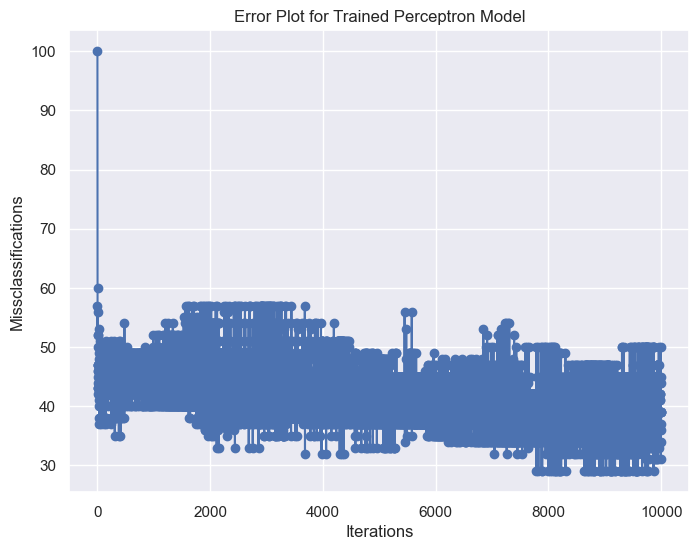

In [7]:
plt.figure(figsize = (8, 6))
plt.plot(range(1, len(clf.errors_)+1), clf.errors_, marker = "o")
plt.xlabel("Iterations")
plt.ylabel("Missclassifications")
plt.title("Error Plot for Trained Perceptron Model")
plt.show()

In [8]:
print("Errors in final iteration:", clf.errors_[-1])
print(f"Misclassification Rate: {round(clf.errors_[-1]/len(y_train)*100, 2)}%")

Errors in final iteration: 39
Misclassification Rate: 5.48%


At first, the training error was high, but by the 10,000th iteration, there are only 39 misclassified errors in the training data. We can also look at the training accuracy.

In [9]:
# Obtain predictions for training set and find the error of the model
y_train_pred = clf.predict(X_train)
print(sum(y_train == y_train_pred) / len(y_train))

0.9803370786516854


98.03% of the training observations are classified correctly!

#### Using model 1 to make predictions for unseen data

In [10]:
# Obtain predictions for testing set and find the test accuracy
y_test_pred = clf.predict(X_test)
print(sum(y_test == y_test_pred) / len(y_test))

0.9888268156424581


98.88% of the test observations are classified correctly. This accuracy is even higher than the training accuracy, which is interesting, since the fitted model is optimized for the training set. Nevertheless, the accuracy of this perceptron model is very high. Next, I will look at the specific misclassifications.

In [11]:
def plot_RT_confusion_matrix(y_actual, y_pred):
    """
    Plots the confusion matrix given the actual and predicted values
    to easily view accurate classifications and type I/II errors
    """             
    classes = [1, -1] # want to invert the order of the classes in outputted matrix
    # Obtain confusion matrix
    cf_matrix = confusion_matrix(y_actual, y_pred, labels=[1, -1])

    # View the confusion matrix using the seaborn package
    plt.figure(figsize = (6, 4))
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')
    ax.set_title('Hawk Species Classification Confusion Matrix\n', fontsize = 14)
    ax.set_xlabel('\nPredicted Values', fontsize = 12)
    ax.set_ylabel('Actual Values ', fontsize = 12)
    ax.xaxis.set_ticklabels(["RT", "Not RT"])
    ax.yaxis.set_ticklabels(["RT", "Not RT"])

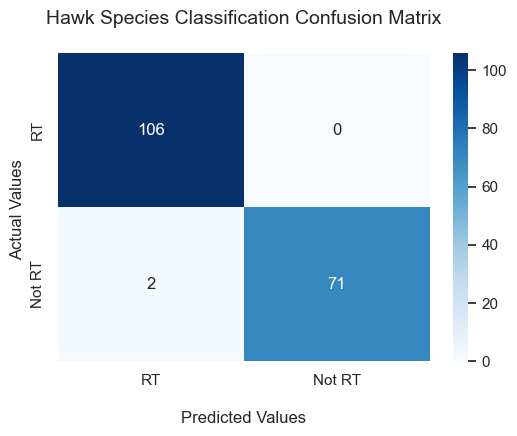

In [12]:
plot_RT_confusion_matrix(y_test, y_test_pred)

For the test data, only 2 hawks are misclassified; there are 2 false positives and no false negatives. The counts along the main diagonal also suggest that the perceptron is able to differentiate between red-tailed and non red-tailed hawks well.

Now, I will look at the classifier's decision regions.

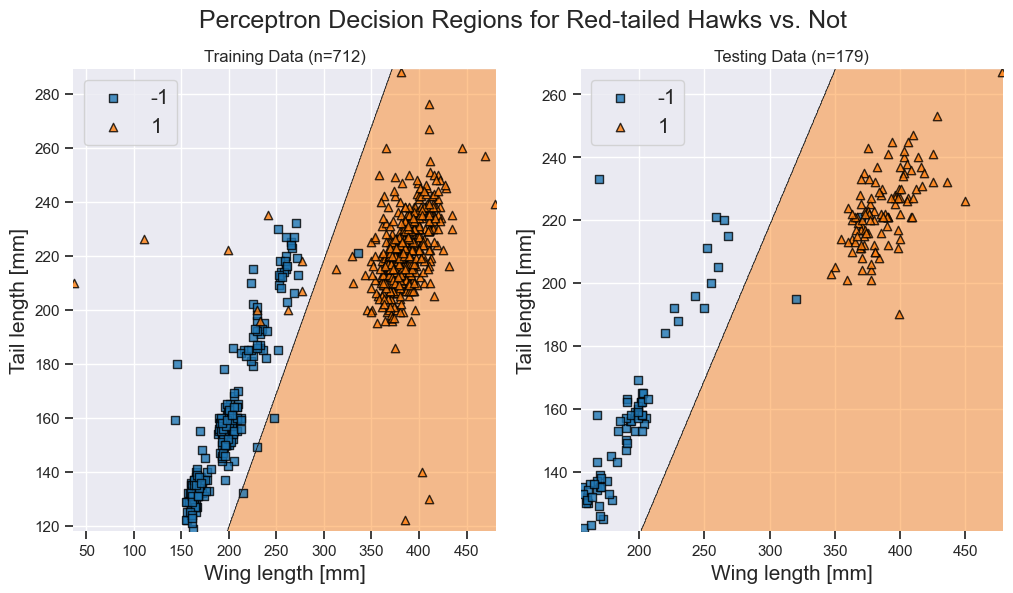

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12,6))
fig.suptitle("Perceptron Decision Regions for Red-tailed Hawks vs. Not", fontsize = 18)
# Produce a scatterplot of tail vs. wing length, color-coded by hawk species
fig = plot_decision_regions(X_train, y_train, clf = clf, ax = axes[0])
axes[0].set_xlabel("Wing length [mm]", fontsize = 15)
axes[0].set_ylabel("Tail length [mm]", fontsize = 15)
axes[0].set_title("Training Data (n=712)", fontsize = 12)
axes[0].legend(fontsize = 15, loc = "upper left")

# Produce a scatterplot of tail vs. wing length, color-coded by hawk species
fig = plot_decision_regions(X_test, y_test, clf = clf, ax = axes[1])
axes[1].set_xlabel("Wing length [mm]", fontsize = 15)
axes[1].set_ylabel("Tail length [mm]", fontsize = 15)
axes[1].set_title("Testing Data (n=179)", fontsize = 12)
axes[1].legend(fontsize = 15, loc = "upper left")
plt.show()

In the left panel, one can see that the perceptron model fitted using the training data is able to capture the pattern well, but it struggles along the border where there are observations that deviate from their main cluster. Specifically, note the 3 blue dots along the line and orange dots that cross over. In the panel on the right that displays the test data, most cases belong in the correct decision region, aside from a few that were anomalies to start with. 

## Model 2: Binary Classification Using 5 Predictors

In addition to wing and tail length, I now run the perceptron with 3 additional hawk features: body weight, culmen length, and hallux (killing talon) length.

An underlying question is whether the inclusion of more features will improve the classification accuracy of the binary hawk species groups.

### Splitting the data to train model 2

In [14]:
X2 = hawks[["Wing", "Tail", "Weight", "Hallux", "Culmen"]].to_numpy()
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y, test_size=0.20, random_state=1)

In [15]:
# Instantiate one instance of the Perceptron class, takes approximately 1 minute to train with 10,000 epochs!
clf2 = MyPerceptron(epochs = 10_000)

# Call the train method to train the weights and bias of the given instance
clf2.train(X_train2, y_train2)
print(clf2.w_)

[  3135.4327511  -13153.79470594    917.41593659   2985.78278813
  47493.94990135  -7177.2241702 ]


### Performance/error analysis for model 2

Next, I will examine the performance of the model, in terms of training error and testing error. Then, I will compare the overall performance of this model relative to model 1. Firstly, I look at the error plot from training the perceptron model.

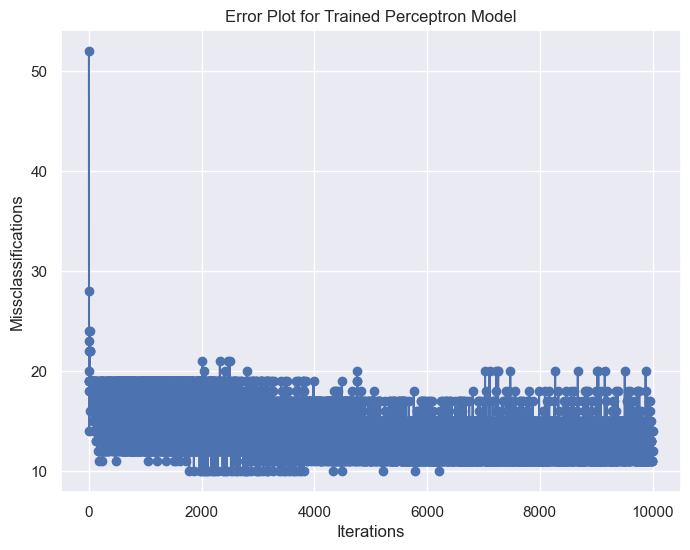

In [16]:
plt.figure(figsize = (8, 6))
plt.plot(range(1, len(clf2.errors_)+1), clf2.errors_, marker = "o")
plt.xlabel("Iterations")
plt.ylabel("Missclassifications")
plt.title("Error Plot for Trained Perceptron Model")
plt.show()

In [17]:
print("Errors in final iteration:", clf2.errors_[-1])
print(f"Misclassification Rate: {round(clf2.errors_[-1]/len(y_train2)*100, 2)}%")

Errors in final iteration: 12
Misclassification Rate: 1.69%


The misclassification rate is lower here than in model 1! Likewise, the training accuracy has increased, to 98.88%, as outputted below.

In [18]:
# Obtain predictions for training set and find the error of the model
y_train_pred2 = clf2.predict(X_train2)
print(sum(y_train2 == y_train_pred2) / len(y_train2))

0.9887640449438202


#### Using model 2 to make predictions for unseen data

In [19]:
# Obtain predictions for testing set and find the test accuracy
y_test_pred2 = clf2.predict(X_test2)
print(sum(y_test2 == y_test_pred2) / len(y_test2))

0.9832402234636871


The accuracy for the testing data is also high, although it is slightly lower than the 98.88% from model 1. Based on the confusion matrix below, there is one additional observation misclassified compared to before; there is now one false negative.

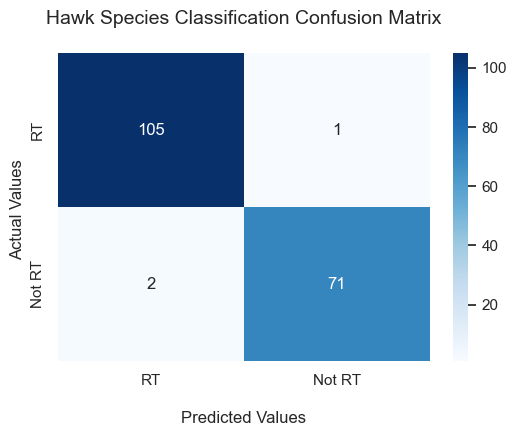

In [20]:
plot_RT_confusion_matrix(y_test2, y_test_pred2)

### Comparing model 1 vs. model 2

Based on the performance and error analysis for both models, while accounting for the models' complexities, I argue that model 1 outshines model 2. Model 2 only has slightly better performance in terms of accuracy, and the false positive/negative rate didn't change much either. However, model 2 has 3 additional predictors relative to model 1. Given the lower complexity of model 1, I would much rather use model 1 to predict whether a hawk is red-tailed or not.

On a closing note, I'm impressed by how this simple algorithm was able to produce high accuracy for this binary classification problem.

## Using scikit-learn

Below, I provide an example of how you would use the scikit-learn library to perform the perceptron for a classification task, using the same training/testing dataset to predict hawk species. I also play around with some of the functions listed in the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html).

In [21]:
from sklearn.linear_model import Perceptron

per_clf = Perceptron()
per_clf.fit(X_train, y_train)
per_clf.intercept_, per_clf.coef_

(array([-96.]), array([[ 1317.6, -2064. ]]))

In [22]:
per_clf.score(X_train, y_train)

0.9564606741573034

In [23]:
per_clf.score(X_test, y_test)

0.9832402234636871

In [24]:
# Predict a hawk's weight given their wing length is 250 mm
per_clf.predict(np.array([250, 300]).reshape(-1, 2))

array([-1])